## FEDn API Example

This notebook provides an example of how to use the FEDn API to organize experiments and to analyze validation results. We will here run one training session using FedAvg and one session using FedAdam and compare the results.

When you start this tutorial you should have a deployed FEDn Network up and running, and you should have created the compute package and the initial model, see the README for instructions.

In [1]:
import sys

venv_path = getattr(sys, 'base_prefix', sys.prefix)
print("Active virtual environment path:", venv_path)

Active virtual environment path: /Users/dininduseneviratne/opt/anaconda3


In [2]:
from fedn import APIClient
import time
import uuid
import json
import matplotlib.pyplot as plt
import numpy as np
import collections

We make a client connection to the FEDn API service. Here we assume that FEDn is deployed locally in pseudo-distributed mode with default ports.

In [3]:
DISCOVER_HOST = '127.0.0.1'
DISCOVER_PORT = 8092
client = APIClient(DISCOVER_HOST, DISCOVER_PORT)

Initialize FEDn with the compute package and seed model. Note that these files needs to be created separately by follwing instructions in the README.

In [36]:
client._get_url('set_package')

'http://127.0.0.1:8092/set_package'

In [37]:
client.list_clients()

{'count': 4,
 'result': [{'combiner': 'combiner',
   'combiner_preferred': False,
   'id': 'benign_client3',
   'ip': '172.19.0.9',
   'last_seen': 'Tue, 20 Feb 2024 11:06:45 GMT',
   'status': 'online'},
  {'combiner': 'combiner',
   'combiner_preferred': False,
   'id': 'benign_client2',
   'ip': '172.19.0.8',
   'last_seen': 'Tue, 20 Feb 2024 11:06:45 GMT',
   'status': 'online'},
  {'combiner': 'combiner',
   'combiner_preferred': False,
   'id': 'malignant_client1',
   'ip': '172.19.0.10',
   'last_seen': 'Tue, 20 Feb 2024 11:06:45 GMT',
   'status': 'online'},
  {'combiner': 'combiner',
   'combiner_preferred': False,
   'id': 'benign_client1',
   'ip': '172.19.0.7',
   'last_seen': 'Tue, 20 Feb 2024 11:06:45 GMT',
   'status': 'online'}]}

In [47]:
# Show running client details
print("Running clients:")
for client in client.list_clients()['result']:
    if client['status'] == 'online':
        print(f"{client['ip']}: {client['id']}")

Running clients:
172.19.0.9: benign_client3
172.19.0.8: benign_client2
172.19.0.10: malignant_client1
172.19.0.7: benign_client1


In [43]:
client.set_package('package.tgz', 'numpyhelper')
client.set_initial_model('seed.npz')
seed_model = client.get_initial_model()

In [62]:
# seed_model
client.list_compute_packages()

{'count': 5,
 'result': [{'committed_at': 'Tue, 20 Feb 2024 11:58:05 GMT',
   'description': None,
   'file_name': 'package.tgz',
   'helper': 'numpyhelper',
   'id': '373ba49b-6079-49e9-ac84-c82c7e2ec2dd',
   'name': None,
   'storage_file_name': 'f0e1e2c8-0a56-4438-8168-2b6c2feb3dcb.tgz'},
  {'committed_at': 'Tue, 20 Feb 2024 11:57:07 GMT',
   'description': None,
   'file_name': 'package.tgz',
   'helper': 'numpyhelper',
   'id': '5d2ccadb-cfa0-4967-bd1b-52503f0facb9',
   'name': None,
   'storage_file_name': '69446e0c-64bd-493f-b274-9eb3f059ebff.tgz'},
  {'committed_at': 'Tue, 20 Feb 2024 11:26:08 GMT',
   'description': None,
   'file_name': 'package.tgz',
   'helper': 'numpyhelper',
   'id': 'd6448a51-9e3a-49f3-87ca-6e5fe2da1154',
   'name': None,
   'storage_file_name': '5a23dd39-4e81-47f9-9462-2b8df1cffcf2.tgz'},
  {'committed_at': 'Tue, 20 Feb 2024 11:26:08 GMT',
   'description': None,
   'file_name': 'package.tgz',
   'helper': 'numpyhelper',
   'id': '854f0895-4390-4c35-862

Next we start a training session using FedAvg and wait until it has finished:

In [45]:
session_id = "experiment_fedavg_01"

session_config_fedavg = {
                    "helper": "numpyhelper",
                    "session_id": session_id,
                    "aggregator": "fedavg",
                    "model_id": seed_model['model_id'],
                    "rounds": 10
                 }

result_fedavg = client.start_session(**session_config_fedavg)

In [63]:
dir(client)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_get_url',
 'download_package',
 'get_active_clients',
 'get_client_config',
 'get_combiner',
 'get_controller_status',
 'get_events',
 'get_initial_model',
 'get_latest_model',
 'get_model_trail',
 'get_package',
 'get_package_checksum',
 'get_round',
 'get_session',
 'host',
 'list_clients',
 'list_combiners',
 'list_compute_packages',
 'list_models',
 'list_rounds',
 'list_sessions',
 'list_validations',
 'port',
 'secure',
 'session_is_finished',
 'set_initial_model',
 'set_package',
 'start_session',
 'verify']

We wait for the session to finish: 

In [51]:
client.session_is_finished('experiment_fedavg_01')

True

In [17]:
while not client.session_is_finished(session_id):
    time.sleep(2)

In [58]:
client.list_models(session_id)

{'count': 10,
 'result': [{'committed_at': 'Tue, 20 Feb 2024 11:33:50 GMT',
   'model': '485e7d67-e4fe-4197-b7d8-c7941ce9f15f',
   'session_id': 'experiment_fedavg_01'},
  {'committed_at': 'Tue, 20 Feb 2024 11:33:06 GMT',
   'model': '6b8e87bb-4630-48e0-94a0-8d4013f48cf1',
   'session_id': 'experiment_fedavg_01'},
  {'committed_at': 'Tue, 20 Feb 2024 11:32:22 GMT',
   'model': 'b9863a8f-91f6-41f8-85d5-9272abbdcbd9',
   'session_id': 'experiment_fedavg_01'},
  {'committed_at': 'Tue, 20 Feb 2024 11:31:34 GMT',
   'model': '5f9c6ed1-8d50-4f58-82ec-d30b06e8346a',
   'session_id': 'experiment_fedavg_01'},
  {'committed_at': 'Tue, 20 Feb 2024 11:30:50 GMT',
   'model': '67642a7b-3312-4538-b006-6a3057c654b9',
   'session_id': 'experiment_fedavg_01'},
  {'committed_at': 'Tue, 20 Feb 2024 11:30:05 GMT',
   'model': 'fba286c8-b0ee-438b-b532-d06adfb1e03a',
   'session_id': 'experiment_fedavg_01'},
  {'committed_at': 'Tue, 20 Feb 2024 11:29:21 GMT',
   'model': 'fda4b653-2be0-4da3-9829-3fb95a17038

In [6]:
client.list_validations()

{'65d48c9b7613a25adef6d148': {'data': '{"training_loss": 1.4829061031341553, "training_accuracy": 0.7531999945640564, "test_loss": 1.392546534538269, "test_accuracy": 0.8059999942779541}',
  'meta': '',
  'model_id': '65c4c90e-5619-4012-886e-5549016bce6c',
  'receiver': {'name': 'combiner', 'role': 'COMBINER'},
  'sender': {'name': 'malignant_client1', 'role': 'WORKER'},
  'timestamp': '2024-02-20T11:27:23.533725Z'},
 '65d48c9b7613a25adef6d149': {'data': '{"training_loss": 1.482998013496399, "training_accuracy": 0.7504000067710876, "test_loss": 1.570511817932129, "test_accuracy": 0.6919999718666077}',
  'meta': '',
  'model_id': '65c4c90e-5619-4012-886e-5549016bce6c',
  'receiver': {'name': 'combiner', 'role': 'COMBINER'},
  'sender': {'name': 'benign_client1', 'role': 'WORKER'},
  'timestamp': '2024-02-20T11:27:23.534433Z'},
 '65d48c9b7613a25adef6d14a': {'data': '{"training_loss": 1.5066980123519897, "training_accuracy": 0.7352666854858398, "test_loss": 1.4036338329315186, "test_accur

Next, we retrive all model validations from all clients, extract the training accuracy metric, and compute its mean value accross all clients

In [59]:
models = client.list_models(session_id)

validations = []
acc = collections.OrderedDict()
for model in models["result"]:
    model_id = model["model"]
    validations = client.list_validations(modelId=model_id)

    for _ , validation in validations.items(): 
        metrics = json.loads(validation['data'])
        try:
            acc[model_id].append(metrics['training_accuracy'])
        except KeyError: 
            acc[model_id] = [metrics['training_accuracy']]
            
mean_acc_fedavg = []
for model, data in acc.items():
    mean_acc_fedavg.append(np.mean(data))
mean_acc_fedavg.reverse()

In [60]:
validations

{'65d48c9b7613a25adef6d148': {'data': '{"training_loss": 1.4829061031341553, "training_accuracy": 0.7531999945640564, "test_loss": 1.392546534538269, "test_accuracy": 0.8059999942779541}',
  'meta': '',
  'model_id': '65c4c90e-5619-4012-886e-5549016bce6c',
  'receiver': {'name': 'combiner', 'role': 'COMBINER'},
  'sender': {'name': 'malignant_client1', 'role': 'WORKER'},
  'timestamp': '2024-02-20T11:27:23.533725Z'},
 '65d48c9b7613a25adef6d149': {'data': '{"training_loss": 1.482998013496399, "training_accuracy": 0.7504000067710876, "test_loss": 1.570511817932129, "test_accuracy": 0.6919999718666077}',
  'meta': '',
  'model_id': '65c4c90e-5619-4012-886e-5549016bce6c',
  'receiver': {'name': 'combiner', 'role': 'COMBINER'},
  'sender': {'name': 'benign_client1', 'role': 'WORKER'},
  'timestamp': '2024-02-20T11:27:23.534433Z'},
 '65d48c9b7613a25adef6d14a': {'data': '{"training_loss": 1.5066980123519897, "training_accuracy": 0.7352666854858398, "test_loss": 1.4036338329315186, "test_accur

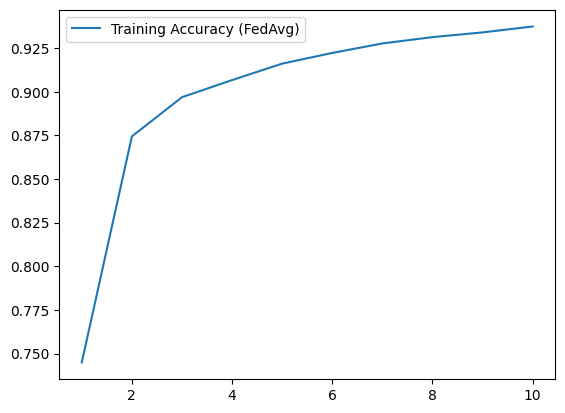

In [61]:
x = range(1,len(mean_acc_fedavg)+1)
plt.plot(x, mean_acc_fedavg)
plt.legend(['Training Accuracy (FedAvg)'])

Let's try another aggregation algorithm. We start another session using FedOpt (FedAdam)

In [22]:
session_config_fedopt = {
                    "helper": "numpyhelper",
                    "session_id": "experiment_fedopt_01",
                    "aggregator": "fedopt",
                    "model_id": seed_model['model_id'],
                    "rounds": 10
                 }

result_fedopt = client.start_session(**session_config_fedopt)

In [9]:
while not client.session_is_finished("experiment_fedopt"):
    time.sleep(2)

In [24]:
client.session_is_finished("experiment_fedopt_01")

True

In [25]:
models = client.list_models(session_id = "experiment_fedopt_01")

validations = []
acc = collections.OrderedDict()
for model in models["result"]:
    model_id = model["model"]
    validations = client.list_validations(modelId=model_id)
    for _ , validation in validations.items(): 
        metrics = json.loads(validation['data'])
        try:
            acc[model_id].append(metrics['training_accuracy'])
        except KeyError: 
            acc[model_id] = [metrics['training_accuracy']]
            
mean_acc_fedopt = []
for model, data in acc.items():
    mean_acc_fedopt.append(np.mean(data))
mean_acc_fedopt.reverse()

Finally, plot the resulting accuracy

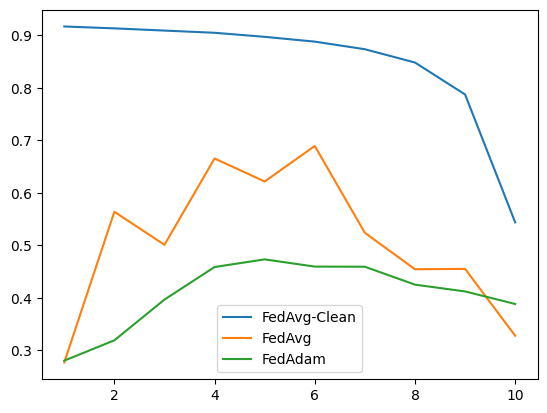

In [41]:
x = range(1,len(mean_acc_fedavg)+1)
plt.plot(x, mean_acc_fedavg_clean, x, mean_acc_fedavg, x, mean_acc_fedopt)
plt.legend(['FedAvg-Clean', 'FedAvg', 'FedAdam'])
plt.show()